<a href="https://colab.research.google.com/github/pumpzcc/EvolutionaryDeepLearning/blob/main/EDL_12_1_GEPPY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install geppy

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 5.0 MB/s eta 0:00:00
  Created wheel for geppy: filename=geppy-0.1.3-py3-none-any.whl size=34964 sha256=439188c7d74e5dc75353ffa44f4dfe659a8b643ccd2c959a89ce2c0e43bc3691
  Stored in directory: /root/.cache/pip/wheels/62/c5/b4/e92589957846dd4984c712d1be535885765588be250b890146
Successfully built geppy


In [5]:
import geppy as gep
from deap import creator, base, tools
import numpy as np
import random

# for reproduction
s = 0
random.seed(s)
np.random.seed(s)

In [6]:
def f(x1):
    """Ground truth function"""
    return 6 * x1 + 22

In [7]:
n_cases = 100
X1 = np.random.uniform(-10, 10, size=n_cases)   # random numbers in range [-10, 10)
Y = f(X1) + np.random.normal(size=n_cases)

In [8]:
def protected_div(x1, x2):
    if abs(x2) < 1e-6:
        return 1
    return x1 / x2

In [9]:
import operator

pset = gep.PrimitiveSet('Main', input_names=['x1'])
pset.add_function(operator.add, 2)
pset.add_function(operator.sub, 2)
pset.add_function(operator.mul, 2)
pset.add_function(protected_div, 2)
pset.add_ephemeral_terminal(name='enc', gen=lambda: random.randint(-10, 10)) # each ENC is a random integer within [-10, 10]

In [10]:
from deap import creator, base, tools

creator.create("FitnessMin", base.Fitness, weights=(-1,))  # to minimize the objective (fitness)
creator.create("Individual", gep.Chromosome, fitness=creator.FitnessMin)

In [11]:
h = 7 # head length
n_genes = 2   # number of genes in a chromosome

In [12]:
toolbox = gep.Toolbox()
toolbox.register('gene_gen', gep.Gene, pset=pset, head_length=h)
toolbox.register('individual', creator.Individual, gene_gen=toolbox.gene_gen, n_genes=n_genes, linker=operator.add)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# compile utility: which translates an individual into an executable function (Lambda)
toolbox.register('compile', gep.compile_, pset=pset)

In [13]:
def evaluate(individual):
    """Evalute the fitness of an individual: MAE (mean absolute error)"""
    func = toolbox.compile(individual)
    Yp = np.array(list(map(func, X1)))
    return np.mean(np.abs(Y - Yp)),

toolbox.register('evaluate', evaluate)

In [14]:
toolbox.register('select', tools.selTournament, tournsize=3)
# 1. general operators
toolbox.register('mut_uniform', gep.mutate_uniform, pset=pset, ind_pb=0.05, pb=1)
toolbox.register('mut_invert', gep.invert, pb=0.1)
toolbox.register('mut_is_transpose', gep.is_transpose, pb=0.1)
toolbox.register('mut_ris_transpose', gep.ris_transpose, pb=0.1)
toolbox.register('mut_gene_transpose', gep.gene_transpose, pb=0.1)
toolbox.register('cx_1p', gep.crossover_one_point, pb=0.4)
toolbox.register('cx_2p', gep.crossover_two_point, pb=0.2)
toolbox.register('cx_gene', gep.crossover_gene, pb=0.1)
toolbox.register('mut_ephemeral', gep.mutate_uniform_ephemeral, ind_pb='1p')  # 1p: expected one point mutation in an individual
toolbox.pbs['mut_ephemeral'] = 1  # we can also give the probability via the pbs property

In [15]:
stats = tools.Statistics(key=lambda ind: ind.fitness.values[0])
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [16]:
# size of population and number of generations
n_pop = 100
n_gen = 100

pop = toolbox.population(n=n_pop)
hof = tools.HallOfFame(3)   # only record the best three individuals ever found in all generations

# start evolution
pop, log = gep.gep_simple(pop, toolbox, n_generations=n_gen, n_elites=1,
                          stats=stats, hall_of_fame=hof, verbose=True)

gen	nevals	avg    	std    	min    	max    
0  	100   	88.6809	272.054	14.8402	2247.94
1  	99    	72.9903	409.881	14.8402	4146.35
2  	99    	114.631	821.196	13.6279	8281.92
3  	99    	44.1602	110.958	8.19233	999.724
4  	99    	28.2697	13.5157	8.19233	96.0449
5  	99    	54.4336	225.532	7.92462	2261.58
6  	99    	118.403	485.201	7.7707 	4118.57
7  	99    	87.9296	306.727	6.19445	2384.42
8  	99    	43.3178	59.0951	5.20662	312.36 
9  	99    	46.6432	79.7068	5.20662	427.293
10 	99    	49.5034	99.3532	5.20662	792.354
11 	99    	34.416 	45.021 	3.19233	330.871
12 	99    	43.7674	128.648	3.19233	1231.57
13 	99    	39.2811	55.4804	3.19233	334.543
14 	99    	55.7693	205.413	2.80767	2006.57
15 	99    	40.5937	74.1986	2.19233	608.161
16 	99    	105.23 	385.437	2.19233	3477.85
17 	99    	32.8945	52.7849	2.19233	367.274
18 	99    	26.7112	29.3625	1.053  	237.61 
19 	99    	34.0062	46.5607	1.053  	285.221
20 	99    	28.603 	35.8615	1.053  	289.261
21 	99    	45.3353	110.74 	1.053  	802.597
22 	99    	

In [17]:
print(hof[0])

add(
	sub(6, x1),
	sub(2, mul(-7, add(x1, 2)))
)


In [18]:
best_ind = hof[0]
symplified_best = gep.simplify(best_ind)
print('Symplified best individual: ')
print(symplified_best)

Symplified best individual: 
6*x1 + 22


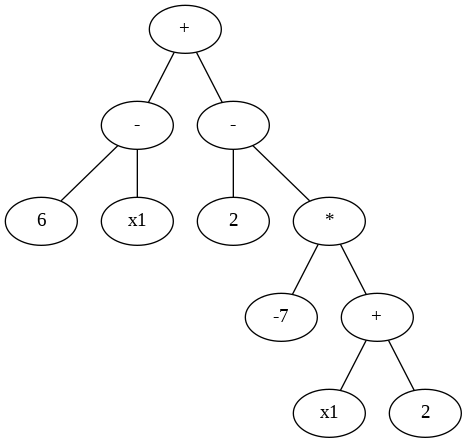

In [19]:
# we want use symbol labels instead of words in the tree graph
rename_labels = {'add': '+', 'sub': '-', 'mul': '*', 'protected_div': '/'}
gep.export_expression_tree(best_ind, rename_labels, 'data/numerical_expression_tree.png')

# show the above image here for convenience
from IPython.display import Image
Image(filename='data/numerical_expression_tree.png')